In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurações pandas
pd.set_option('display.max_rows', 200) # define a quantidade de visualização na hora de printar
pd.set_option('display.max_columns', 100) # define a quantidade de visualização na hora de printar

# Configurações Matplotlib
plt.rcParams['figure.figsize'] = (15, 6) # Tamanho dos graficos
plt.style.use('seaborn-darkgrid') # Estilo dos Gráficos

C:\Users\IMendes_41\AppData\Local\Temp\ipykernel_17244\870818468.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid') # Estilo dos Gráficos


# **Exploração dos Dados**

In [3]:
base = pd.read_csv('house_data.csv')

# (Linhas e colunas)
base.shape

(10692, 13)

In [4]:
base.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [5]:
# Drop Columns
base.drop(columns=['fire insurance (R$)', 'total (R$)'], inplace=True) # O inplace apaga da direto na base

In [6]:
# campos vazios mostra os valores nulos em cada coluna
base.isnull().sum().sort_values(ascending=False)

city                 0
area                 0
rooms                0
bathroom             0
parking spaces       0
floor                0
animal               0
furniture            0
hoa (R$)             0
rent amount (R$)     0
property tax (R$)    0
dtype: int64

In [7]:
# campos unicos
base.nunique()

city                    5
area                  517
rooms                  11
bathroom               10
parking spaces         11
floor                  35
animal                  2
furniture               2
hoa (R$)             1679
rent amount (R$)     1195
property tax (R$)    1243
dtype: int64

In [8]:
# tipos das colunas
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   city               10692 non-null  object
 1   area               10692 non-null  int64 
 2   rooms              10692 non-null  int64 
 3   bathroom           10692 non-null  int64 
 4   parking spaces     10692 non-null  int64 
 5   floor              10692 non-null  object
 6   animal             10692 non-null  object
 7   furniture          10692 non-null  object
 8   hoa (R$)           10692 non-null  int64 
 9   rent amount (R$)   10692 non-null  int64 
 10  property tax (R$)  10692 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 919.0+ KB


# **Exploração Analitica (EDA)**

In [9]:
# filtro de colunas

colunasQualitativas = base.columns[ base.dtypes == object]
colunasQuantitativas = base.columns[ base.dtypes != object]

In [10]:
# Analise dos campos objetos

for coluna in colunasQualitativas:
    analise = base[coluna].value_counts(normalize=True) * 100 # Normalize - normaliza os dados dentro de 0 ou 1(ou seja, porcentagem).

    print(coluna, '\n' , analise, '\n')

city 
 city
São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: proportion, dtype: float64 

floor 
 floor
-      23.017209
1      10.110363
2       9.212495
3       8.707445
4       6.995885
5       5.611672
6       5.041152
7       4.648335
8       4.582866
9       3.451178
10      3.338945
11      2.833895
12      2.403666
13      1.870557
14      1.589974
15      1.374860
16      1.019454
17      0.897868
18      0.701459
19      0.495698
20      0.411523
21      0.392817
25      0.233820
23      0.233820
22      0.224467
26      0.187056
24      0.177703
27      0.074822
28      0.056117
29      0.046764
32      0.018706
35      0.009353
46      0.009353
301     0.009353
51      0.009353
Name: proportion, dtype: float64 

animal 
 animal
acept        77.777778
not acept    22.222222
Name: proportion, dtype: float64 

furniture 
 furniture
not furnished    75.626637
furnished        24.373

In [11]:
import psycopg
def GetDadosBD(sql, cabecalhos):
    try:
        connect = psycopg.connect(
            host="psql.ci0871wedpdp.us-east-1.rds.amazonaws.com",
            port="5432",
            dbname="core",
            user="postgres",
            password="pgimendes")

        # criando a classe cursor que é usada para gerenciar atributos de dados
        cur = connect.cursor()

        sql = sql.replace('/[\\"]/g', '')

        # Executando o comando
        cur.execute(sql)
        results = cur.fetchall()
        connect.commit()

        # Fechando o cursor e a conexão
        cur.close()
        connect.close()

        if len(results) < 1:
            df = pd.DataFrame()

            for cabecalho in cabecalhos:
                df[f'{cabecalho}'] = [1,1]

            return df

        else:
            # Transformando os resultados em um DataFrame
            df = pd.DataFrame(results, columns=cabecalhos)
            return df

    except Exception as e:
        return f'{e}'

In [12]:
sql = f"""SELECT cnpjcpf "cnpj", situacao "Situacao"
    FROM gestor.pesqclientes
    WHERE dtcadastro BETWEEN '2023-09-01' AND '2023-09-30'
    AND dtvalidade BETWEEN '2023-09-01' AND '2023-09-30'"""

tablesql = GetDadosBD(
    sql, ['cnpj', 'Situacao'])
tablesql['Situacao'] = tablesql['Situacao'].replace(["1", "B", "C", "D", "H", "N", "S"], [
                                                    "Normal", "Bloqueado", "Cancelado", "Degustação", "Homologação", "Normal", "Suspenso"])
tablesqlNormal = tablesql[tablesql['Situacao'] == 'Normal']
tablesql['Situacao'] = tablesql['Situacao'].apply(lambda Registro : '0' if Registro == 'Normal' else Registro)
tablesql

,cnpj,Situacao
0,52004785000506,Homologação
1,09418668000551,0
2,09418668000632,0
3,09418668000713,0
4,09418668001019,0
5,09418668000985,0


In [13]:
base.loc[base['floor'] == '301'] = 30
base.iloc[ 2562, 5] = 30 # acessa o indice da linha 2562 e a coluna 5 e muda para 30

base['floor'] = base['floor'].apply(lambda Registro : 0 if Registro == '-' else Registro) # faz um for nas linhas dessa coluna
base['floor'] = pd.to_numeric(base['floor']) # muda o tipo da coluna para inteiro

C:\Users\IMendes_41\AppData\Local\Temp\ipykernel_17244\1896855756.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(Linhas, Colunas, Posicao)
C:\Users\IMendes_41\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\IMendes_41\AppData\Local\Temp\ipykernel_17244\1896855756.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to us

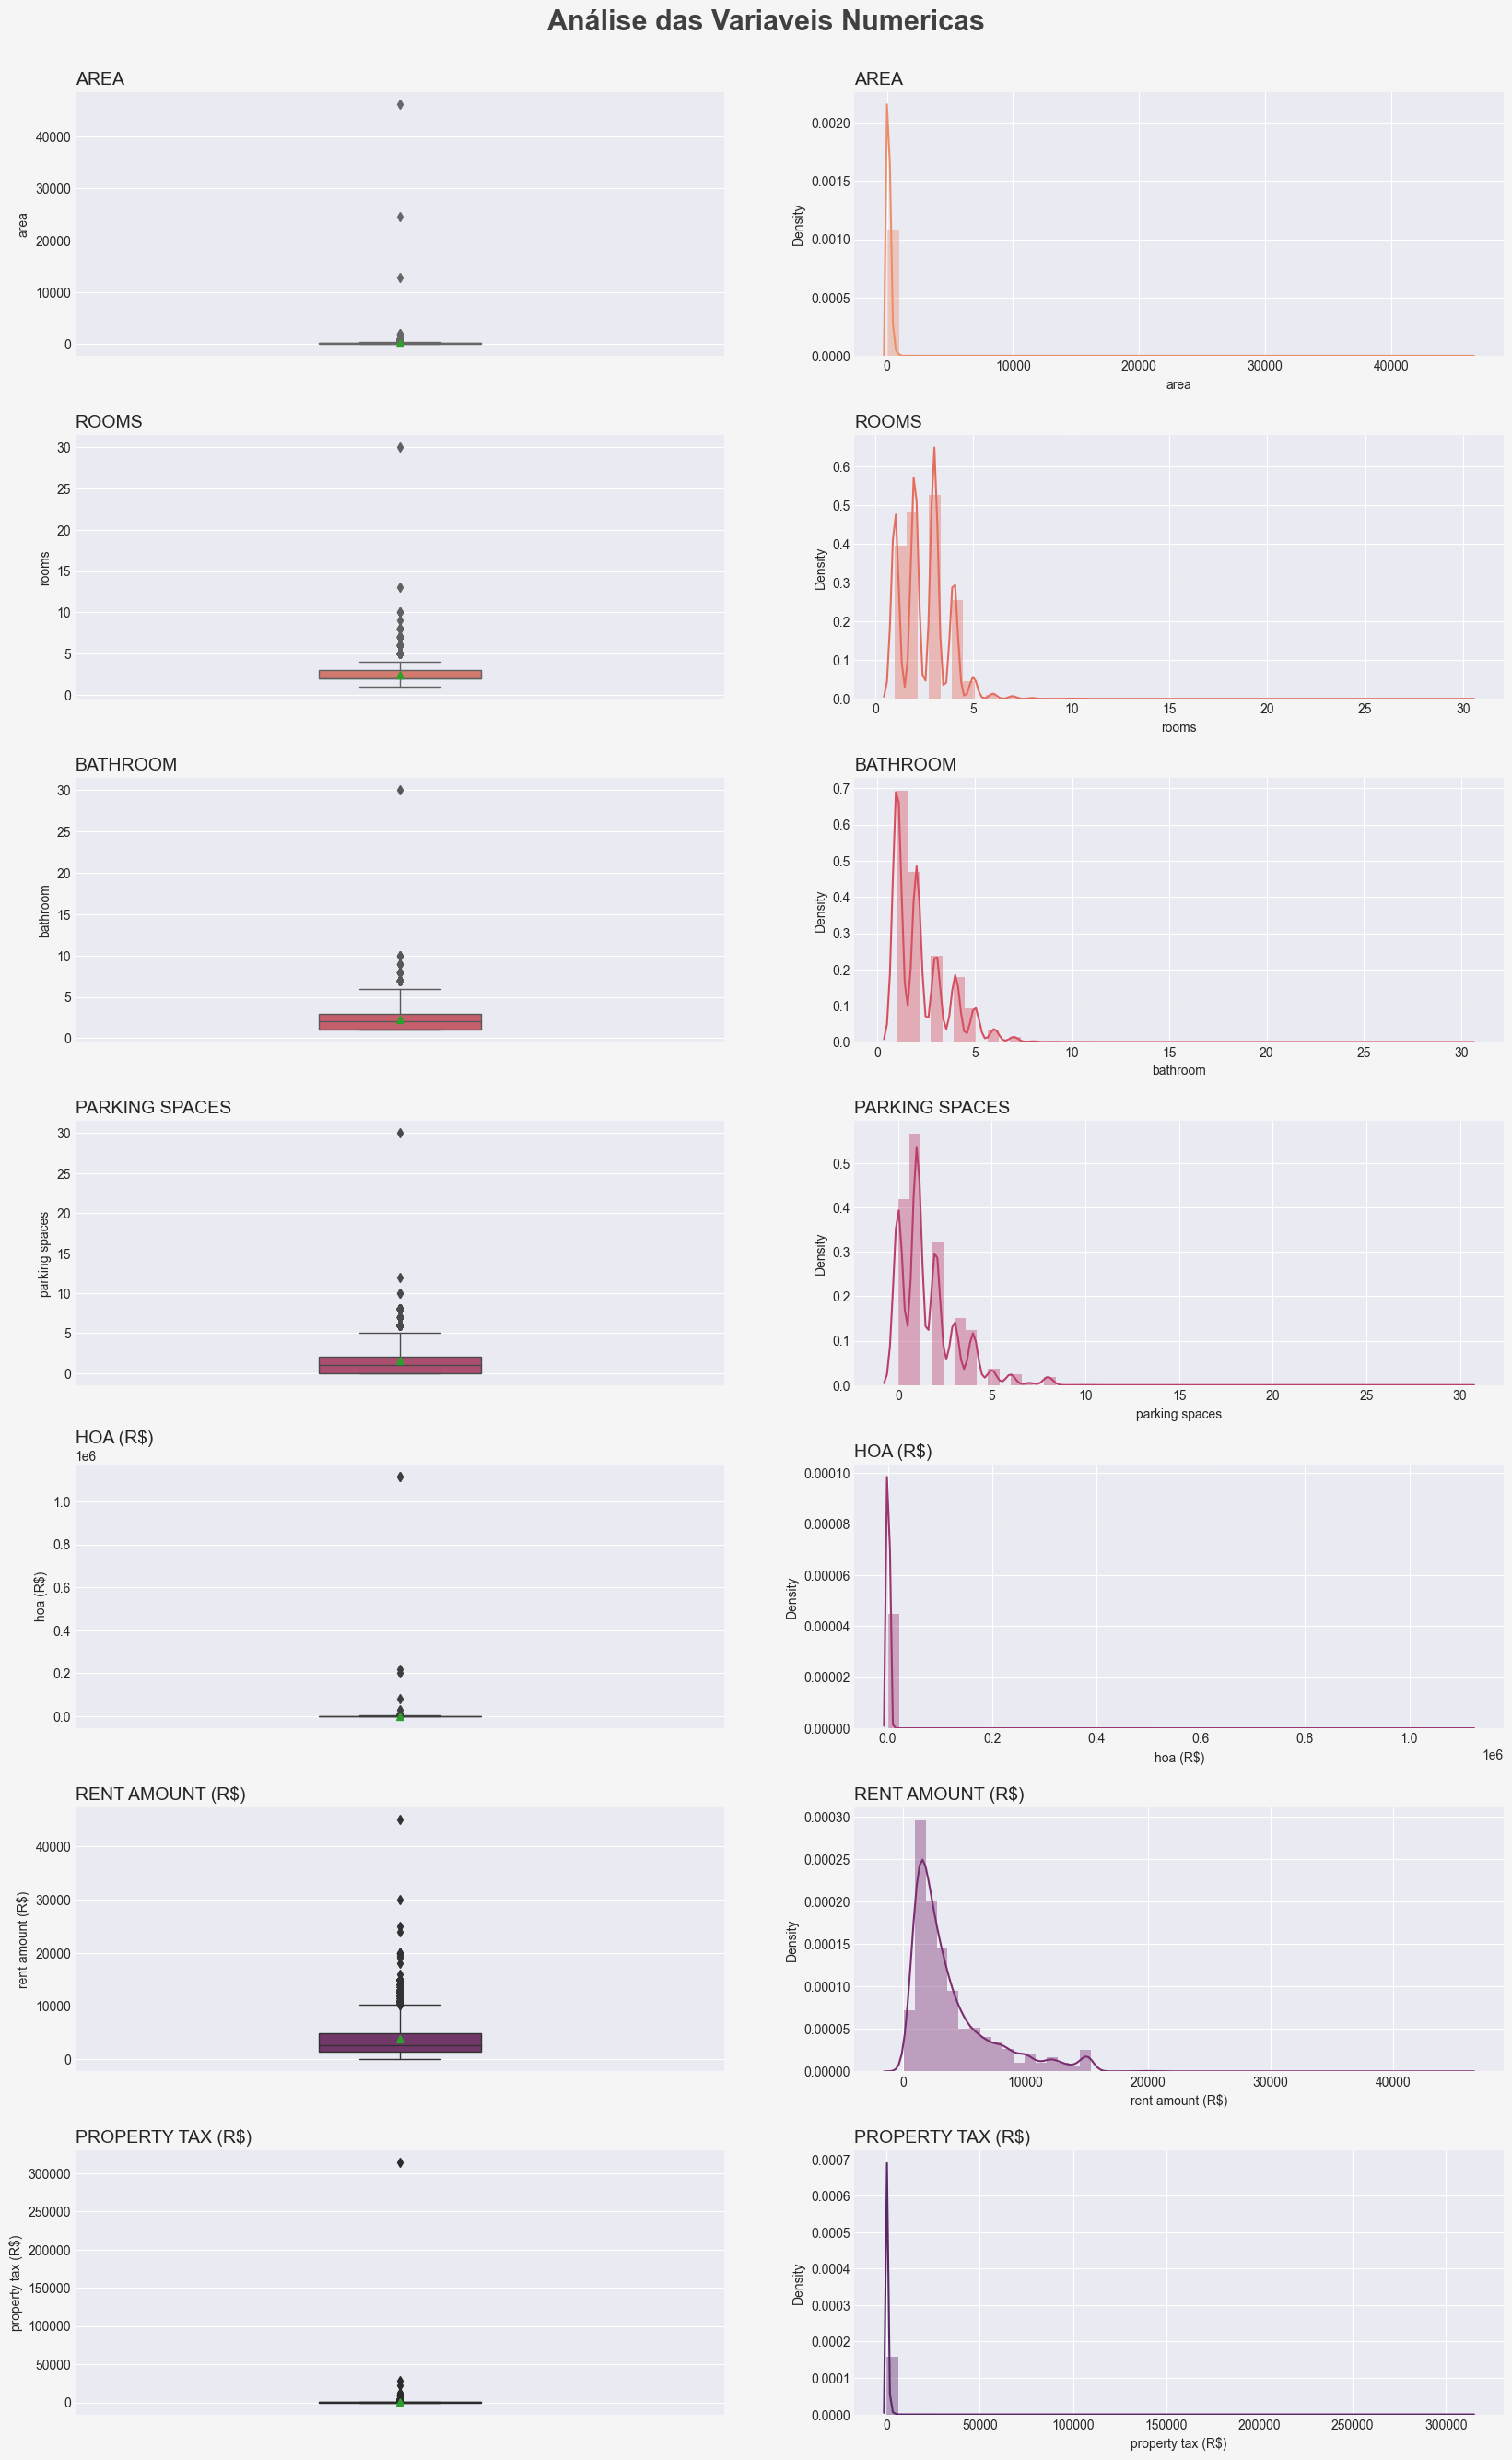

In [14]:
# Grid - Gráficos

# Tamanho
Figura, Eixo = plt.subplots(figsize=(20, 30))

# Cor de fundo
Cor_Fundo = '#f5f5f5'
Figura.set_facecolor(Cor_Fundo)

# Paleta de Cores
Paleta_Cores = sns.color_palette( 'flare', len(colunasQuantitativas) * 2 )

# Titulo
plt.suptitle('Análise das Variaveis Numericas', fontsize=22, color='#404040', fontweight=600 )

# Estrutura
Linhas = 7 # (Todas as infos numericas)
Colunas = 2 #( Boxplot - Distplot)
Posicao = 1 # Posicao inicial do grid

# Loop para plotar os gráficos
for Coluna in colunasQuantitativas:

  # Plot no Grid -- Boxplot
  plt.subplot(Linhas, Colunas, Posicao)

  # Titulo
  plt.title(f'{Coluna.upper()}', loc='left', fontsize=14, fontweight=200)

  # Plot
  sns.boxplot(data=base, y=Coluna, showmeans=True, saturation=0.75, 
              linewidth=1, color=Paleta_Cores[Posicao], width=0.25)

  # Mudar
  Posicao += 1

  # Plot no Grid -- Distplot
  plt.subplot( Linhas, Colunas, Posicao )

  # Titulo
  plt.title( f'{Coluna.upper()}', loc='left', fontsize=14, fontweight=200 )

  # Plot
  sns.distplot(base[Coluna], color=Paleta_Cores[Posicao - 1])

  # Mudar
  Posicao += 1

# Ajute de Grid
plt.subplots_adjust( top=0.95, hspace=0.3 )

In [15]:
base.loc[base['area'] <= 10000]['area'].describe() # std = desvio padrao

count    10689.000000
mean       141.427168
std        134.351228
min         11.000000
25%         56.000000
50%         90.000000
75%        182.000000
max       2000.000000
Name: area, dtype: float64

In [16]:
base.loc[base['hoa (R$)'] <= 10000]['hoa (R$)'].describe() # std = desvio padrao

count    10683.000000
mean       911.882430
std       1104.917359
min          0.000000
25%        170.000000
50%        557.000000
75%       1230.000000
max      10000.000000
Name: hoa (R$), dtype: float64

# **Engenharia de Features**
- *Analise das variáveis que vão ser levadas em conta no modelo*
- *Analise somente para São Paulo *

In [ ]:
# Ajuste das colunas categoricas
base['animal'] = base['animal'].map( {'acept':1, 'not acept':0} )
base['furniture'] = base['furniture'].map( {'furnished':1, 'not furnished':0} )

# Filtrar a Cidade de São Paulo
Filtro_SP = base.loc[ base['city'] == 'São Paulo']

# Verificar
Filtro_SP.head()

In [20]:
# Separa os dados
Caracteristicas = Filtro_SP.drop( columns=['rent amount (R$)'] )
Previsor = Filtro_SP['rent amount (R$)']

# VErificar
Caracteristicas.shape, Previsor.shape

((5887, 9), (5887,))

In [ ]:
# Previsoor
Previsor.head()

In [ ]:
# Correlação
Filtro_SP.corr()

# Proxima de 1 - Correlação Possitva [ Ambas Sobem ]
# Proxima de -1 - Correlação Negativa [ Uma sobe outra desce ]

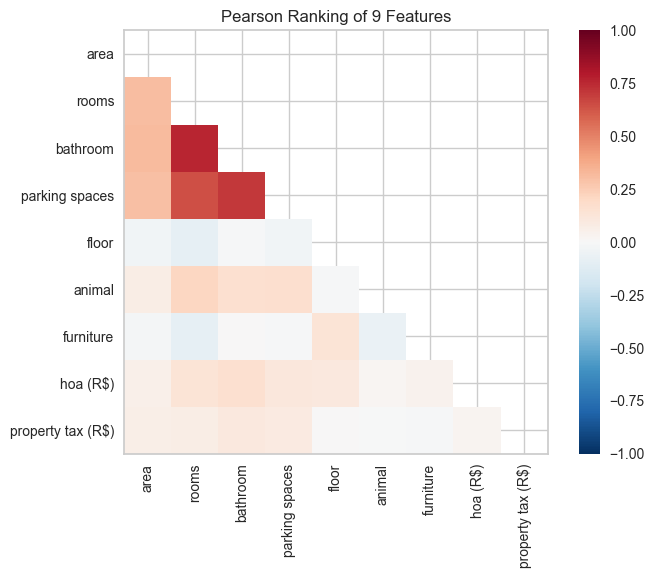

<Axes: title={'center': 'Pearson Ranking of 9 Features'}>

In [24]:
# Biblioteca YellowBrick
from yellowbrick.features import Rank2D

correlacao = Rank2D(algoritmo='pearson')

correlacao.fit(Caracteristicas, Previsor)
correlacao.transform(Caracteristicas)
correlacao.show()

In [26]:
# Separar dados
from sklearn.model_selection import train_test_split

# Divisão dos dados - divide entre dados de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    Caracteristicas, Previsor, test_size=0.2, random_state=10
)

print(f'Dados de Treino: { x_treino.shape[0] }') # - o resultado disso traz quantos registros vao ser treinados
print(f'Dados de Teste: { x_teste.shape[0] }')# - o resultado disso traz quantos registros vao ser testados

Dados de Treino: 4709
Dados de Teste: 1178


In [29]:
# Features mais relevantes
# avalia a dependencia entre duas variaveis(se for igual a 0 nao existe dependencia)
from sklearn.feature_selection import mutual_info_regression 
# seleciona as maiores features
from sklearn.feature_selection import SelectKBest


# Selecao de features
def SelecaoFeatures(x_treino, y_treino):

  # Configurar para selecionar as features
  Selecao = SelectKBest(score_func=mutual_info_regression, k=5)

  # Fitar o aprendizado
  Selecao.fit(x_treino, y_treino)

  return Selecao

# Chamar Funcao
scores = SelecaoFeatures(x_treino, y_treino)

# scores.scores_ traz as melhores features do modelo
for index, score in enumerate(scores.scores_):
  print(f'{x_treino.columns[index]} - {score}')

area - 0.5118192573840039
rooms - 0.24661004934695763
bathroom - 0.33685338875896464
parking spaces - 0.291598257111636
floor - 0.084187214075647
animal - 0.02461823383701134
furniture - 0.020330143405933754
hoa (R$) - 0.37897074330159386
property tax (R$) - 0.4186370219671245


# Construção do Modelo

In [ ]:
# Algoritmo que funciona a base de arvores de decisão e traz qual arvore traz um resultado melhor
from sklearn.ensemble import RandomForestRegressor

modeloFloresta = RandomForestRegressor()

modeloFloresta.fit(x_treino, y_treino)

In [33]:
# Avaliar a performance
previsoes = modeloFloresta.predict(x_teste)

previsoes

array([1128.  , 9571.6 , 6799.87, ..., 2299.  , 5928.9 , 2990.31])

In [42]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# MOSTRA EM MEDIA O QUANTO O MODELO ESTA ERRANDO NAS PREVISOES
print(f'RMSF: {sqrt(mean_squared_error(y_teste, previsoes))}')
# O quanto o modelo se explica
print(f'Score: {r2_score(y_teste, previsoes)}')

RMSF: 2410.491985995673
Score: 0.57946411372069


In [ ]:
# Yellowbrick
from yellowbrick.regressor import PredictionError

modelo = RandomForestRegressor(max_depth=5)
erroModelo = PredictionError(modelo)

erroModelo.fit(x_treino, y_treino)
erroModelo.score(x_teste, y_teste)
erroModelo.show()

# Exportação Modelo

In [53]:
from joblib import dump

dump(modeloFloresta, 'ModeloFloresta-v1.0.pkl')

['ModeloFloresta-v1.0.pkl']